<a href="https://colab.research.google.com/github/WALLERR/Covid-19-Infection-Percentage-Estimation/blob/main/covid19_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Prediction

Since late 2019, the world been in health crisis because of the COVID-19 pandemic. In fact, using Medical Imagery has proved to be efficient in detecting Covid-19 Infection. These Medical Imaging include: X-ray, CT-scans and Ultrasounds. The use of CT-scans is not only limited to the detection of COVID-19 cases, but they can also be used for other important tasks such quantifying the infection and monitoring the evolution of the disease, which can help in treatment and save the patient’s life. In this challenge, the participants will use a dataset labelled by two expert radiologists, who estimated the Covid-19 infection, to train and validate their approaches. In the testing phase, participants will test their approaches using a test dataset collected from various CT-scanners and recording settings.

- In your google drive, create a folder called "DL_Project"
- Place this .ipynb notebook in that folder
- Upload the training & val dataset zip in that folder
- Only have to do this once the very first time you are setting up project

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # if you haven't unzipped training data
# !unzip "/home/mac/Covid-19-Infection-Percentage-Estimation/Train.zip" -d  "/home/mac/Covid-19-Infection-Percentage-Estimation/Train/"

In [ ]:
# if you haven't unzipped val data
# !unzip "/home/mac/Covid-19-Infection-Percentage-Estimation/Val Blind.zip" -d  "/home/mac/Covid-19-Infection-Percentage-Estimation/Val Blind"

## Challenge Dataset:

The challenge has three sets: Train, Val, and Test, and we will only work with the Train set and Val set (unlabeled). 

The Train set is obtained from 132 CT-scans, from which 128 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest four CT-scans have not any infection type (Healthy). The Val set is obtained from 57 CT-scans, from which 55 CT-scans has confirmed to have Covid-19 based on positive reverse transcription polymerase chain reaction (RT-PCR) and CT scan manifestations identified by two experienced thoracic radiologists. The rest two CT-scans have not any infection type (Healthy).

The Train split has two files: Images (Slices) Folder and Labeling Folder ('.csv' file) that contains the labels for each Slice (Image)

    Train Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
    |      └ Image_3053.png
    ├── Labeling Folder
    │   └── Train.csv
    │         ├ Slice_Name        Covid-19_percentage  Subject    
    │         ├ Image_0000.png    0.0                  0
    │         ├ Image_0001.png    0.0                  0
    │         ├ ...               ...                  ..
    │         └ Image_3053.png    40.0	               131
    └── 

The Validation split has one file contains the slices images, which will be used to predict the Covid-19 infection percentage. These prediction should be saved as '.csv' file and submitted to the Codalab (https://competitions.codalab.org/competitions/35575) to evaluation the performance:

    Val Set
    ├── Slices Folder 
    │      ├ Image_0000.png
    │      ├ Image_0001.png
    │      ├ ...
     |      └ Image_1300.png
    └── 

## Deliverables

In the Validation phase, each team should submit the predictions of the validation data as 'predictions.csv' file, which contains the names of the slice images in the first column and the corresponding Covid-19 infection percentage estimation in the second column. **This file should be compressed as 'predictions.zip' file and submitted to CodaLab**.

In order to have access to the leader board, you must do the following:
- Participation in the Competition: Each team should request to participate in the competition on the CodaLab platform (https://competitions.codalab.org/competitions/35575) with specifying the team name, members, emails and affiliations. The team informations can be send to: faresbougourzi@gmail.com

    predictions.zip
    ├── predictions.csv
    │      ├ Image_0000.png    Pr0            
    │      ├ Image_0001.png    Pr1             
    │      ├ ...               ...              
    │      └ Image_1300.png    Pr1300	        
    └──   

## Evaluation

The evaluation metrics are: **Mean Absolute Error (MAE), Pearson Correlation coefficient (PC) and Root Mean Square Error (RMSE)**. The most important Evaluation Criterion is the **MAE**. In the event of two or more competitors achieve the same MAE, the PC and the RMSE are considered as the tie-breaker.

## Custom Dataset Class

In [ ]:
## preprocess data
## create custom data class

import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

from datetime import date, datetime


class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
            self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        return sample

In [ ]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/Colab Notebooks/Train.csv',
                                    root_dir='drive/MyDrive/Colab Notebooks/Train'
                                    #, transform = transforms.Compose([
                                    #           Rescale(256),
                                    #           RandomCrop(224),
                                    #           ToTensor()
                                    #       ])
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/Colab Notebooks/Val')

0 torch.Size([3, 512, 512]) 0.0 0
1 torch.Size([3, 512, 512]) 0.0 0
2 torch.Size([3, 512, 512]) 0.0 0
3 torch.Size([3, 512, 512]) 0.0 0


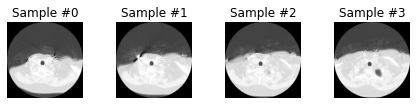

In [ ]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

0 torch.Size([3, 512, 512]) drive/MyDrive/Colab Notebooks/Val/Image_0304.png
1 torch.Size([3, 512, 512]) drive/MyDrive/Colab Notebooks/Val/Image_0301.png
2 torch.Size([3, 512, 512]) drive/MyDrive/Colab Notebooks/Val/Image_0303.png
3 torch.Size([3, 512, 512]) drive/MyDrive/Colab Notebooks/Val/Image_0302.png


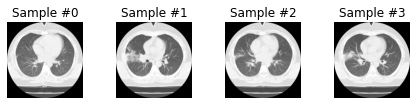

In [ ]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

##Split given train set to train & val set

In [ ]:
# please skip this section if you do not want to normalize the training and testing data

# When using resnet 152 and resnet 101, please use batch_size = 4
train_val_set = DataLoader(covid_dataset_train_val, batch_size=4, shuffle=True, num_workers=0)
test_set = DataLoader(covid_dataset_test, batch_size=4, shuffle=True, num_workers=0)

# When using resnet 34 and resnet 50, please use batch_size = 8
# train_val_set = DataLoader(covid_dataset_train_val, batch_size=8, shuffle=True, num_workers=0)
# test_set = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

pixel_sum = torch.tensor([0.0, 0.0, 0.0])
pixel_var = torch.tensor([0.0, 0.0, 0.0])

for inputs in train_val_set:
    # calculate the sum of the pixels
    pixel_sum = pixel_sum + inputs['image'].sum(axis = [0, 2, 3])

    # calculate the squared value of pixels
    pixel_var = pixel_var + (inputs['image'] ** 2).sum(axis = [0, 2, 3])

for inputs in test_set:

    pixel_sum = pixel_sum + inputs['image'].sum(axis = [0, 2, 3])
    pixel_var = pixel_var + (inputs['image'] ** 2).sum(axis = [0, 2, 3])

    
count = (len(covid_dataset_train_val) + len(covid_dataset_test)) * 512 * 512

# mean = sum / pixel count
mean = pixel_sum  / count

# variance = squared pixel / pixel count - mean^2
var  = (pixel_var/ count) - (mean ** 2)
std  = torch.sqrt(var)

mean=[0.4945, 0.4945, 0.4945]
std=[0.3744, 0.3744, 0.3744]

# mean = np.array(mean)
# std = np.array(std)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/Colab Notebooks/Train.csv',
                                       root_dir='drive/MyDrive/Colab Notebooks/Train',
                                       transform = train_transform)

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/Colab Notebooks/Val',
                                      transform = train_transform)


In [ ]:

## split given train set to train & val set

#dataloader = DataLoader(covid_dataset, batch_size=4, shuffle=True, num_workers=0)
# print(len(covid_dataset_train_val))
train_size = int(0.7 * len(covid_dataset_train_val))
val_size = len(covid_dataset_train_val) - train_size
# print(train_size, val_size)

train_dataset, val_dataset = torch.utils.data.random_split(covid_dataset_train_val, [train_size, val_size])

# For resnet 34 and 50, batch_size should be set to 8
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
# val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

# For resnet 101 and 152, batch_size should be set to 4
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

## test set
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

## Import pretrained models library

In [ ]:
# ## use imagenet pretrained model
# ## let's start with resnet34
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d145a99de51ad93b4ffba66ae131237c6a323b66c00f46f0e8ff940285dc69bf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


## Use CUDA to speed up training

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Baseline Model

In [ ]:
import pretrainedmodels
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

In [ ]:
class CNN1(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)

        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

class CNN2(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN2, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

class CNN3(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet101"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet101"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        
        self.conv1 = nn.Conv2d(2048, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

class CNN4(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN4, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet152"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet152"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(2048, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label


In [ ]:
torch.cuda.empty_cache()

model_CNN = CNN4(True).to(device)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

## Create a SAM for the Optimizer

In [ ]:
# credits to: https://github.com/AnujCodeZ/ImageCLFUsingEffNetWithSAM/tree/0d683100ef3d546fc837eb9fe0449c20bdb2b0d9

import torch

rho = 0.05
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.005

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
#Setting model and moving to device
criterion = nn.L1Loss()

#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)

optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)


# base_optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = SAM(model_CNN.parameters(), 
#                 base_optimizer, 
#                 rho=rho, 
#                 lr=learning_rate, 
#                 momentum=momentum, 
#                 weight_decay=weight_decay)

In [ ]:
def train_model(model, criterion, optimizer, n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    trainloss=[]
    testloss=[]
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        trainloss.append(train_loss)
        testloss.append(valid_loss)               
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            # torch.save(model, 'training_log/model_' + model.get_pretrianed_model_name() + '_' + str(today) + '.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return (model, trainloss, testloss)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.empty_cache()

In [ ]:

model_conv = train_model(model_CNN, criterion, optimizer)

Epoch 1, Batch 1 loss: 30.337370
Epoch 1, Batch 101 loss: 18.470491
Epoch 1, Batch 201 loss: 17.859289
Epoch 1, Batch 301 loss: 17.396137
Epoch 1, Batch 401 loss: 17.762394
Epoch 1, Batch 501 loss: 17.595839
Epoch: 1 	Training Loss: 17.515612 	Validation Loss: 15.415020
Validation loss decreased (inf --> 15.415020).  Saving model ...
Epoch 2, Batch 1 loss: 24.720182
Epoch 2, Batch 101 loss: 16.784414
Epoch 2, Batch 201 loss: 17.374186
Epoch 2, Batch 301 loss: 16.751059
Epoch 2, Batch 401 loss: 16.390043
Epoch 2, Batch 501 loss: 16.713989
Epoch: 2 	Training Loss: 16.969444 	Validation Loss: 16.058834
Epoch 3, Batch 1 loss: 13.073294
Epoch 3, Batch 101 loss: 14.721651
Epoch 3, Batch 201 loss: 14.894619
Epoch 3, Batch 301 loss: 15.301888
Epoch 3, Batch 401 loss: 14.514127
Epoch 3, Batch 501 loss: 13.659059
Epoch: 3 	Training Loss: 13.395611 	Validation Loss: 8.394993
Validation loss decreased (15.415020 --> 8.394993).  Saving model ...
Epoch 4, Batch 1 loss: 6.555739
Epoch 4, Batch 101 lo

In [ ]:
trainloss=[]
testloss=[]
for i in model_conv[1]:
    trainloss.append(i.tolist())
for i in model_conv[2]:
    testloss.append(i.tolist())

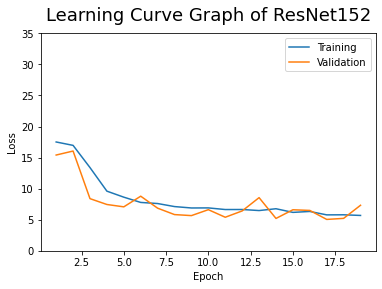

In [ ]:
import matplotlib.pyplot as plt

# plt.style.use('seaborn')

plt.plot(range(1,20), trainloss, label = 'Training')
plt.plot(range(1,20), testloss, label = 'Validation')


plt.ylabel('Loss')
plt.xlabel('Epoch')


plt.title('Learning Curve Graph of ResNet152', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,35)

plt.savefig('drive/MyDrive/Colab Notebooks/books_read.png')

## Save result on Actual Val Data to csv File

In [ ]:
df = pd.DataFrame(columns=['image_name','output'])
for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model_conv[0](image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    a = np.concatenate((img_name,o),axis=1)
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    

In [ ]:
#Extracting image name from the image path
df['image_name']=df['image_name'].str.split("/").str[-1]

# sort the image results by the image names
df = df.sort_values('image_name')

In [ ]:
df.to_csv('drive/MyDrive/Colab Notebooks/predictions.csv', index=False, header=False)

## Emply the ensemble methods by averaging the results obtained by several models

In [ ]:
# Read the results from other prediction result

other_results = 'Predictions/predictions-ResNet 50 + Normalized.csv'

col_Names=["image_name", "output"]

df2 = pd.read_csv(other_results,names=col_Names)

# calculate the average value of predictions
# round up the averaged value
averaged_pred = ((df2+df)/2).round()

df2['output'] = averaged_pred

df.to_csv('drive/MyDrive/Colab Notebooks/predictions_new.csv', index=False, header=False)

## Points to note:

General Rules: Participants should estimate the percentage of Covid-19 infection from each slice using Machine Learning. **Only ImageNet's pre-trained models and Lung Nodule Segmentation models are allowed**. The use of external data or other pre-trained models is not allowed. The models must be trained using the training data and evaluated using the validation data.

##Things you can try:

- The dataset is not as big and especially negative covid images are very few.
It would be better to use k-fold cross validation rather than conventional splitting.
- How would you split image splices from the same patient subject into train & val set?
- How would the information on the patient (subject #) help your prediction?
- What kind of preprocessing/data augmentation method help your model? What kind of methods would actually make your model perform worse?
- What other different CNN architectures could you explore to acheive lower MAE?
- Explore different optimizers, loss combinations, etc
- Explore different regularization methods

This is no way an exhaustive list. You might get a better idea by reading relevant research papers. Good luck!

## Wasted Method

In [ ]:
# Use albumentation to modify the input images
# But this method is not useful

class args:
    batch_size = 8
    #image_size = 384
    image_size=384
    epochs =20
    fold=0

class CovidDataset:
    def __init__(self,image_paths,targets,augmentations):
        self.image_paths = image_paths
        self.targets = targets
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations is not  None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        
        image = np.transpose(image,(2,0,1)).astype(np.float32)
        
        targets = self.targets[item]
        
        return {
            "image":torch.tensor(image,dtype=torch.float),
            "targets":torch.tensor(targets,dtype=torch.float)
        }

class CovidModel(tez.Model):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("swin_large_patch4_window12_384_in22k",pretrained=True,in_chans=3)
        self.model.head = nn.Linear(self.model.head.in_features,128)
        
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(128,64)
        self.dense2 = nn.Linear(64, 1)
        self.step_scheduler_after = "epoch"
    
    def monitor_metrics(self,outputs,targets):
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        rmse = metrics.mean_squared_error(targets,outputs,squared=False)
        return {"rmse":rmse}
    
    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer,T_0 =10,T_mult=1, eta_min=1e-6,last_epoch=-1
               )
        return  sch 
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(),lr=1e-4)
        return opt
    
    def forward(self,image,targets=None):
        x = self.model(image)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        
        if targets is not None:
            loss = nn.MSELoss()(x,targets.view(-1,1))
            metrics = self.monitor_metrics(x,targets)
            return x,loss,metrics
        
        return x,0,{}
    
train_aug = albumentations.Compose([
    albumentations.Resize(args.image_size,args.image_size,p=1),
    albumentations.HueSaturationValue(
        hue_shift_limit=0.2,
        sat_shift_limit =0.2,
        val_shift_limit=0.2,
        p=0.5
    ),
    albumentations.RandomBrightnessContrast(
        brightness_limit=(-0.1,0.1),
        contrast_limit =(-0.1,0.1),p=0.5
    ),

    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0
    ),
],p=1.0)

valid_aug  = albumentations.Compose([
    
    albumentations.Resize(args.image_size,args.image_size,p=1),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
        p=1.0,
    
    ),
],p=1.0)

train_dataset = CovidDataset(
    image_paths = train_img_paths,
    targets= df_train.per.values,
    augmentations=train_aug
)
valid_dataset = CovidDataset(
    image_paths = valid_img_paths,
    targets = df_valid.per.values,
    augmentations=valid_aug 
)